In [1]:
import os, sys
import torch
import importlib
import pdb
sys.path.append('../')

In [2]:
import torch
import importlib 


import matplotlib.pyplot as plt
from celluloid import Camera

from IPython.display import HTML

from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss
from functools import partial

/Users/daalvare/.ve/gficnn/lib/python3.7/site-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


In [3]:
import src.icnn
importlib.reload(src.icnn)
from src.icnn import FICNN

import src.utils
importlib.reload(src.utils)
from src.utils import test_convexity, test_weights, test_hessian, PositiveWeightClipper
from src.utils import net_batch_gradients


            
# V1. Fails sometimes. See https://stackoverflow.com/questions/61308237/cannot-find-in-place-operation-causing-runtimeerror-one-of-the-variables-neede                                                                                                    
# def jacobian(y, x, create_graph=False):                                                               
#     jac = []                                                                                          
#     flat_y = y.reshape(-1)                                                                            
#     grad_y = torch.zeros_like(flat_y)                                                                 
#     for i in range(len(flat_y)):                                                                      
#         grad_y[i] = 1.                                                                                
#         grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph,  allow_unused=True)
#         jac.append(grad_x.reshape(x.shape))                                                           
#         grad_y[i] = 0.                                                                                
#     return torch.stack(jac).reshape(y.shape + x.shape)                                                
                                                          
                                       
def f(x):                                                                                             
    return x * x * torch.arange(4, dtype=torch.float)                                                 
                                   
def f(x):                                                                                             
    return 0.5*x@x   

# def f(x):                                                                                             
#     return torch.dot(torch.randn(x.shape[0]), x)
    

# x = torch.ones(4, requires_grad=True)                                                                 
# print(jacobian(f(x), x))                                                                              
# print(hessian(f(x), x))    
# #def test_hessian(f):


In [4]:
from src.utils import jacobian, hessian

d = 5


#u = LinearFConvex(5, None, 2).eval()
u = FICNN(input_dim=d, hidden_dims=[100,100],dropout=0,nonlin='leaky_relu').eval()


x = torch.randn(1,d, requires_grad=True).squeeze()

#with torch.autograd.set_detect_anomaly(True):
J = jacobian(u(x), x)
H = hessian(u(x), x).squeeze()

torch.eig(H, eigenvectors=False).eigenvalues

test_weights(u)


test_convexity(u, strict=False)

test_hessian(u, strict=False)

Convexity (via curvature) violated for 0/1000 tested pairs at tolerance 1e-08.
Convexity (via Hessian) violated for 0/10 tested pairs at tolerance 1e-08.


In [5]:
#print(X.shape)
#gradient_penalty(u, X).shape

net_batch_gradients(u, x)

tensor([-0.0147,  0.7410,  0.0052,  0.1779, -0.1673], grad_fn=<ViewBackward>)

### Generate Data for Flow

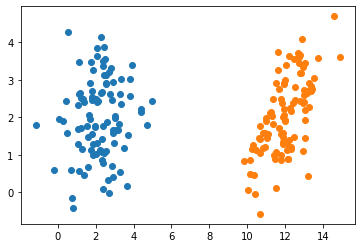

In [45]:
# Source
Σ0 = torch.Tensor([[1,0],[0,1]])
μ0 = torch.Tensor([2.0,2.0])
ρ0 = torch.distributions.multivariate_normal.MultivariateNormal(μ0, Σ0)
X = ρ0.sample(sample_shape=(100,))


# Target
Σ1 = torch.Tensor([[1,0.5],[0.5,1]])
μ1 = μ0 + torch.Tensor([10.0,0.0])
ρ1 = torch.distributions.multivariate_normal.MultivariateNormal(μ1, Σ1)
Y = ρ1.sample(sample_shape=(100,))


fig, ax = plt.subplots()
ax.scatter(*X.T)
ax.scatter(*Y.T)
plt.show()


In [7]:
def rbf_kde_entropy(X, Y, bw=0.1):
    # Computes E_p(X) log p_{Y; KDE}(x).
    # output is size: X.shape[0]
    nx = X.shape[0]
    ny = Y.shape[0]
    
    # Plain pytorch
    D = torch.cdist(X, Y).pow(2)/bw
    #print(D.shape)
    logK = torch.logsumexp(-D, dim= 1)
    
    # Empirical approx 
    logd = logK.mean() - ny/nx
    return logd




def rbf_kde_entropy(X, Y, bw=0.1):
    # Computes E_p(X) log p_{Y; KDE}(x).
    # output is size: X.shape[0]
    nx = X.shape[0]
    ny = Y.shape[0]
    
    # With keops - see https://www.kernel-operations.io/
    #from pykeops.torch import LazyTensor
    # Here, the kernel density estimation   a_i = sum_j exp(-|x_i-y_j|^2)
    # is computed using a CUDA online map-reduce routine that has a linear    
    # memory footprint and outperforms standard PyTorch implementations
    # by two orders of magnitude.    
    #x_i = LazyTensor( X[:,None,:] )  # x_i.shape = (1e6, 1, 3)
    #y_j = LazyTensor( Y[None,:,:] )  # y_j.shape = ( 1, 2e6,3)
    #D_ij = ((x_i - y_j)**2/bw).sum(dim=2)  # Symbolic (1e6,2e6,1) matrix of squared distances
    #K_ij = (- D_ij).exp()               # Symbolic (1e6,2e6,1) Gaussian kernel matrix
    #a_i = K_ij.sum(dim=1)  # Genuine torch.cuda.FloatTensor, a_i.shape = (1e6, 1),
    #logd = a_i.sum() - nx/ny

    # Plain pytorch
    D = torch.cdist(X, Y).pow(2)/bw
    #print(D.shape)
    logK = torch.logsumexp(-D, dim= 1)
    
    
    # Empirical approx 
    logd = logK.mean() - ny/nx
    return logd

    
def empirical_entropy(X):
    D = torch.cdist(X, X) + 1e6*torch.eye(X.shape[0])
    return torch.log(D.min(dim=1)[0]).sum()


def KL_loss(X, ρ, Y=None, entropy=False, kde_bw=0.1):
    # Empirical KL loss: Σ_x log ρ(x)
    if not entropy or Y is None:
        return -ρ.log_prob(X).mean()
    else:
        #print(-ρ.log_prob(X).mean() , rbf_kde(X, Y))
        a = ρ.log_prob(X).mean() 
        #b = rbf_kde_entropy(X, X, bw = kde_bw)
        b = empirical_entropy(X)
        print(-a, b)
        return -a - b

print(rbf_kde_entropy(X, X, 1e2))

print(empirical_entropy(X))

KL_loss(Y, ρ1, Y, True)


tensor(3.5646)
tensor(-165.9299)
tensor(2.7023) tensor(-171.6414)


tensor(174.3437)

In [8]:
rbf_kde_entropy(X, X, bw = 1e-5)

tensor(-1.0198)

In [13]:
X.norm(dim=1).shape

torch.Size([100])

In [64]:
import src.flow 
importlib.reload(src.flow)
from src.flow import GradFlow
from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss
from functools import partial
from src.utils import hessian
import importlib
import src.flow
importlib.reload(src.flow)

from src.flow import logdet_estimate



from src.flow import PotentialFunctional, EntropyFunctional, FunctionalSum, GeomLossFunctional


# V = PotentialFunctional(lambda x: torch.norm(x, dim=1))


# # print(X.norm(), Y.norm())

# # print(V.V)
# # print(V(g=X))
# # print(asd.asd)

# # EntropyFunctional(x=X)


# # Sinkhorn divergence as Functional
# ot_loss = SamplesLoss("energy", p=2, blur=.05, debias=True)   #Other options: loss='energy', 'laplacian', 'gaussian' (MMD)
# F = partial(ot_loss, Y) # F(rho) = SD(rho, \beta)
# f_input_type = '∇x'

# # # KL divergence as Functional
# # F = partial(KL_loss, ρ=ρ1, Y=Y, entropy=True, kde_bw=2e0)
# # f_input_type = '∇x'

# print(F(X))

# #F(rho) = -  \int   log p (x)  rho(x) dx + entropy (rho)

# # Entropy via Hessian 
# F = lambda u, x: - torch.logdet(hessian(u(x), x))
# f_input_type = 'u,x'

# # F = lambda gx, x: - torch.logdet(jacobian(gx, x))
# # f_input_type = '∇x,x'


# F = lambda Hx: - torch.logdet(Hx).mean()
# f_input_type = 'Hx'

# #print(F(u, X))


F = logdet_estimate
f_input_type = 'x,hvp'


#### 


F = EntropyFunctional()
fname = 'flow_ent'


F = GeomLossFunctional(Y, 'sinkhorn')
fname = 'flow_sink'

F = FunctionalSum([EntropyFunctional(), GeomLossFunctional(Y, 'sinkhorn')])
fname = 'flow_sink_ent'





#X = torch.randn(100,2)

#fname = f'flow_τ{gf.τ}_lr{gf.lr}_it{gf.opt_iters}'
save_path = os.path.join('../out/toy/', fname)




gf = GradFlow(X, F=F, Y=Y, τ=1e0, lr = 1e-3, opt_iters=500, f_input_type=f_input_type, save_path = save_path)

XT = gf.flow(steps=20)

print(X.norm(), Y.norm())
#print(F(X), F(XT))

HTML(gf.animation.to_html5_video())



Step: 0
It   l_W    l_F    l+     ||X||  ||T(X)||
   0   2.40  60.91  62.11   2.95   1.46
 499  24.60  12.22  24.52   2.95   7.39
Step: 1
It   l_W    l_F    l+     ||X||  ||T(X)||
   0   3.00  17.13  18.63   7.39   6.42
 499   6.13   3.43   6.50   7.39   9.77
Step: 2
It   l_W    l_F    l+     ||X||  ||T(X)||
   0  25.09   6.29  18.83   9.77  14.50
 499   1.53   1.36   2.12   9.77  10.96
Step: 3
It   l_W    l_F    l+     ||X||  ||T(X)||
   0   5.88   6.56   9.50  10.96   8.63
 499   0.41   0.83   1.03  10.96  11.58
Step: 4
It   l_W    l_F    l+     ||X||  ||T(X)||
   0  15.27   6.78  14.42  11.58  15.42
 499   0.11   0.72   0.77  11.58  11.90
Step: 5
It   l_W    l_F    l+     ||X||  ||T(X)||
   0   8.53   4.57   8.83  11.90  14.75
 499   0.03   0.69   0.71  11.90  12.07
Step: 6
It   l_W    l_F    l+     ||X||  ||T(X)||
   0   0.91   1.11   1.56  12.07  12.85
 499   0.01   0.69   0.70  12.07  12.16
Step: 7
It   l_W    l_F    l+     ||X||  ||T(X)||
   0   0.99   0.97   1.46  12.15  11.22


In [67]:
X

tensor([[ 4.9470,  2.4257],
        [ 2.5417,  2.9135],
        [ 3.6403,  0.1730],
        [ 1.7330,  3.4793],
        [ 3.0281,  1.9853],
        [ 2.0384,  1.3209],
        [ 2.0031,  2.4922],
        [ 2.7031, -0.0284],
        [ 2.3328,  1.4250],
        [ 3.3184,  2.3589],
        [ 2.0447,  2.4120],
        [ 2.6623,  0.3421],
        [ 1.5205,  1.7690],
        [ 2.5542,  2.8727],
        [ 4.3896,  2.1312],
        [ 0.4943,  1.5941],
        [ 0.5091,  4.2706],
        [ 2.3567,  1.7655],
        [ 2.2030,  1.1326],
        [ 2.3791,  3.3716],
        [ 2.3844,  0.0994],
        [ 1.7860,  2.7105],
        [ 1.7890,  2.4595],
        [ 2.3288,  2.6591],
        [ 1.8709,  3.2451],
        [ 2.8927,  0.4135],
        [ 1.3773,  2.4172],
        [ 1.8024,  1.5635],
        [ 1.6840,  1.9445],
        [ 0.2815,  1.8965],
        [ 1.8710,  1.2854],
        [ 1.8591,  1.0037],
        [ 2.8547,  0.7099],
        [ 2.2942,  2.6438],
        [ 3.8293,  3.0130],
        [ 2.9340,  1

In [69]:
x

tensor([[-5.0000, -3.8889, -2.7778, -1.6667, -0.5556,  0.5556,  1.6667,  2.7778,
          3.8889,  5.0000],
        [-5.0000, -3.8889, -2.7778, -1.6667, -0.5556,  0.5556,  1.6667,  2.7778,
          3.8889,  5.0000],
        [-5.0000, -3.8889, -2.7778, -1.6667, -0.5556,  0.5556,  1.6667,  2.7778,
          3.8889,  5.0000],
        [-5.0000, -3.8889, -2.7778, -1.6667, -0.5556,  0.5556,  1.6667,  2.7778,
          3.8889,  5.0000],
        [-5.0000, -3.8889, -2.7778, -1.6667, -0.5556,  0.5556,  1.6667,  2.7778,
          3.8889,  5.0000],
        [-5.0000, -3.8889, -2.7778, -1.6667, -0.5556,  0.5556,  1.6667,  2.7778,
          3.8889,  5.0000],
        [-5.0000, -3.8889, -2.7778, -1.6667, -0.5556,  0.5556,  1.6667,  2.7778,
          3.8889,  5.0000],
        [-5.0000, -3.8889, -2.7778, -1.6667, -0.5556,  0.5556,  1.6667,  2.7778,
          3.8889,  5.0000],
        [-5.0000, -3.8889, -2.7778, -1.6667, -0.5556,  0.5556,  1.6667,  2.7778,
          3.8889,  5.0000],
        [-5.0000, -

(10, 10) (10, 10) (100, 2)
torch.Size([100, 2]) torch.Size([10, 10]) torch.Size([10, 10])


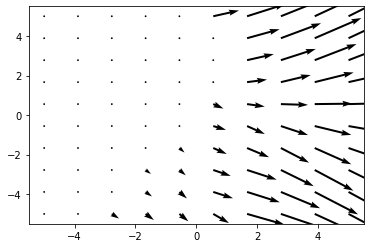

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# X = np.arange(-10, 10, 1)
# Y = np.arange(-10, 10, 1)
# U, V = np.meshgrid(X, Y)


x,y = np.meshgrid(np.linspace(-5,5,10),np.linspace(-5,5,10))
XY = np.vstack([x.flatten(),y.flatten()]).T

print(x.shape, y.shape, XY.shape)

x = torch.tensor(x)
y = torch.tensor(y)
z = torch.tensor(XY).float()

z_ = z.clone().requires_grad_(True)
ux = gf.ut(z_)
Tz = torch.autograd.grad(ux.sum(), z_, create_graph=True)[0].detach()

u = Tz[:,0].reshape(x.shape)
v = Tz[:,1].reshape(y.shape)
print(Tz.shape, u.shape, v.shape)


plt.quiver(x,y,u,v)
plt.show()


# fig, ax = plt.subplots()
# q = ax.quiver(X, Y, U, V)
# ax.quiverkey(q, X=0.3, Y=1.1, U=10,
#              label='Quiver key, length = 10', labelpos='E')

# plt.show()



In [60]:
from src.utils import net_batch_gradients
def net_batch_hessian(net, x):
    x_ = x.clone().detach().requires_grad_(True)
    fx = net(x_)
    musk = torch.ones_like(fx)
    g = torch.autograd.grad(fx, x_, grad_outputs=musk,
                     retain_graph=True, create_graph=True,
                     allow_unused=True)[0]  # get tensor from tuple
    
    h = torch.autograd.grad(g, x_, grad_outputs=musk,
                     retain_graph=True, create_graph=False,
                     allow_unused=True)[0] 
    return h

n, d = 10, 5
u = FICNN(input_dim=d, hidden_dims=[100,100],dropout=0,nonlin='leaky_relu').eval()


x = torch.randn(n,d, requires_grad=True).squeeze()


Tx = net_batch_gradients(u, x)
print(Tx.shape)

# Hx = net_batch_hessian(u, x)


# # #with torch.autograd.set_detect_anomaly(True):
# # J = jacobian(u(x), x)
# # H = hessian(u(x), x).squeeze()

v = lambda x: u(x).squeeze()

# Tx2 = torch.autograd.functional.jacobian(v, x, create_graph=False, strict=False)
# print(x.shape, u(x).shape, Tx2.shape)

# print(Tx)
# print(Tx2.squeeze())


Hux = torch.stack([torch.autograd.functional.hessian(u, x[i], create_graph=False, strict=False) for i in range(x.shape[0])])
print(Hux.shape)
for i in range(x.shape[0]):
    a = torch.logdet(Hux[i])
    b = torch.log(torch.diag(Hux[i])).sum()
    print(a, b, a-b)
# Hx = torch.stack([torch.autograd.functional.hessian(v, x[i], create_graph=False, strict=False) for i in range(x.shape[0])])
# print(Hx.shape)
#Hux

torch.Size([10, 5])
torch.Size([10, 5, 5])
tensor(-6.2937) tensor(-6.0692) tensor(-0.2245)
tensor(-5.6657) tensor(-5.4352) tensor(-0.2306)
tensor(-5.7677) tensor(-5.6478) tensor(-0.1199)
tensor(-7.1107) tensor(-6.8976) tensor(-0.2130)
tensor(-7.3116) tensor(-7.1337) tensor(-0.1780)
tensor(-5.2617) tensor(-5.0681) tensor(-0.1936)
tensor(-6.2671) tensor(-6.1870) tensor(-0.0801)
tensor(-6.9804) tensor(-6.7228) tensor(-0.2576)
tensor(-7.4429) tensor(-6.9766) tensor(-0.4662)
tensor(-5.5710) tensor(-5.3984) tensor(-0.1726)


In [91]:
bw = 1e0
print(KL_loss(X, ρ=ρ1, Y=Y, entropy=True, kde_bw=bw))
print(KL_loss(Y, ρ=ρ1, Y=Y, entropy=True, kde_bw=bw))


tensor(2.6134)
tensor(4.6697)


In [10]:
norms = []
for i,row in enumerate(π_pot):
    j = np.argmax(row)
    TXi = TX[i,:]
    πXi = Y[j,:]
    norms.append((TXi - πXi).norm())
    
error = np.array(norms).mean()
print(error)

0.4985471


In [11]:
def mccann_interp(u, X, steps):
    """ X: (n x d), output: (n x d x nsteps)"""
    TX = net_batch_gradients(u, X).detach()
    
    TtX = []
    for t in np.linspace(0,1,steps+1):
        TtX.append(((1-t)*X + t*TX))
    return torch.stack(TtX)#.transpose(0,2)
    
    
interps = mccann_interp(u, X, 10)


In [12]:
interps.shape

torch.Size([11, 100, 2])

100


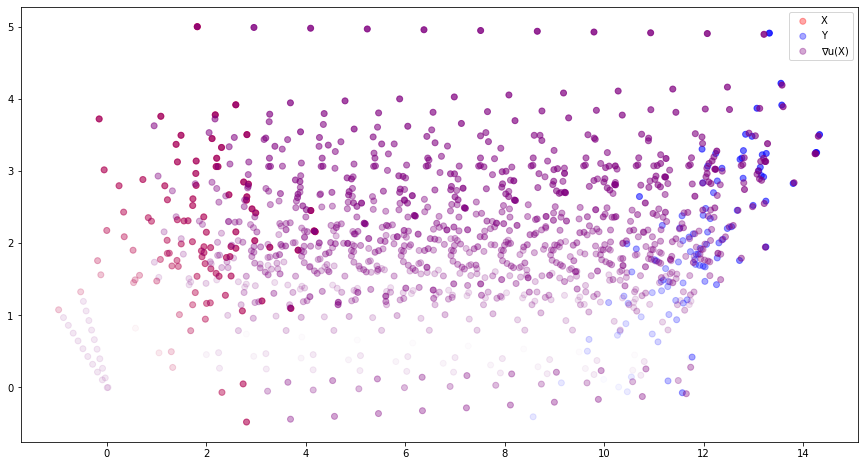

In [16]:
import numpy as np
from matplotlib.colors import to_rgb, to_rgba

#colors =  np.arange(X.shape[0])
alpha_arr = np.sqrt((X[:,0]**2 +X[:,1]**2))
alpha_arr = (alpha_arr - alpha_arr.min())/alpha_arr.max()

print(len(alpha_arr))
# Function to get graded color to pass to scatter
alpha_col = lambda alphas, color: np.array([to_rgb(color)+(alpha,) for alpha in alpha_arr])

fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(*X.T, c = alpha_col(alpha_arr, 'red'), label='X')
ax.scatter(*Y.T, c = alpha_col(alpha_arr, 'blue'), label='Y')
plot_interpolation = True
if plot_interpolation:
    for t, Xt in enumerate(interps):
        ax.scatter(*Xt.T, c = alpha_col(alpha_arr, 'purple'), label='∇u(X)' if t==0 else None)
else:    
    ax.scatter(*TX.T, c = alpha_col(alpha_arr, 'purple'), label='∇u(X)')
ax.legend()
plt.show()


In [85]:
import torch.nn as nn

class mmd2_noise_injection(torch.autograd.Function):

    @staticmethod
    def forward(ctx,true_feature,fake_feature,noisy_feature):
        b_size,d, n_particles = noisy_feature.shape
        with  tr.enable_grad():

            mmd2 = tr.mean((true_feature-fake_feature)**2)
            mean_noisy_feature = tr.mean(noisy_feature,dim = -1 )

            mmd2_for_grad = (n_particles/b_size)*(tr.einsum('nd,nd->',fake_feature,mean_noisy_feature) - tr.einsum('nd,nd->',true_feature,mean_noisy_feature))

        ctx.save_for_backward(mmd2_for_grad,noisy_feature)

        return mmd2

    @staticmethod
    def backward(ctx, grad_output):
        mmd2_for_grad, noisy_feature = ctx.saved_tensors
        with  tr.enable_grad():
            gradients = autograd.grad(outputs=mmd2_for_grad, inputs=noisy_feature,
                        grad_outputs=grad_output,
                        create_graph=True, only_inputs=True)[0]
        return None, None, gradients


class MMD(nn.Module):
    def __init__(self, f):
        self.f = f
        self.mmd2 = mmd2_noise_injection.apply
        
    def forward(self, x, y):
        fake = torch.mean(self.f(x), dim=-1)
        loss = 0.5*torch.mean((y-fake).pow(2))
        return loss

f_μν = 
F = MMD()

SyntaxError: invalid syntax (<ipython-input-85-a4df1454cf5c>, line 40)

In [17]:
import torch
import pykeops

# Turn our Tensors into KeOps symbolic variables:
from pykeops.torch import LazyTensor
x_i = LazyTensor( X[:,None,:] )  # x_i.shape = (1e6, 1, 3)
y_j = LazyTensor( Y[None,:,:] )  # y_j.shape = ( 1, 2e6,3)

# # We can now perform large-scale computations, without memory overflows:
D_ij = ((x_i - y_j)**2).sum(dim=2)  # Symbolic (1e6,2e6,1) matrix of squared distances
K_ij = (- D_ij).exp()               # Symbolic (1e6,2e6,1) Gaussian kernel matrix

# And come back to vanilla PyTorch Tensors or NumPy arrays using
# reduction operations such as .sum(), .logsumexp() or .argmin().
# Here, the kernel density estimation   a_i = sum_j exp(-|x_i-y_j|^2)
# is computed using a CUDA online map-reduce routine that has a linear
# memory footprint and outperforms standard PyTorch implementations
# by two orders of magnitude.
a_i = K_ij.sum(dim=1)  # Genuine torch.cuda.FloatTensor, a_i.shape = (1e6, 1),
g_x = torch.autograd.grad((a_i ** 2).sum(), [x])  # KeOps supports autograd!

Compiling libKeOpstorch724f90b8f1 in /Users/daalvare/.cache/pykeops-1.4-cpython-37/build-libKeOpstorch724f90b8f1:
       formula: Sum_Reduction(Exp(Minus(Sum(Square((Var(0,2,0) - Var(1,2,1)))))),0)
       aliases: Var(0,2,0); Var(1,2,1); 
       dtype  : float32
... 

FileNotFoundError: [Errno 2] No such file or directory: 'cmake': 'cmake'

In [21]:
torch.cdist(X, Y).shape

torch.Size([100, 100])

tensor(3.5710)
tensor(-188.4088)
tensor(-inf)


In [147]:

import torch
x = torch.randn(100000, 3, requires_grad=True)#.cuda()
y = torch.randn(200000, 3)#.cuda()

# Turn our Tensors into KeOps symbolic variables:
from pykeops.torch import LazyTensor
x_i = LazyTensor( x[:,None,:] )  # x_i.shape = (1e6, 1, 3)
y_j = LazyTensor( y[None,:,:] )  # y_j.shape = ( 1, 2e6,3)

# We can now perform large-scale computations, without memory overflows:
D_ij = ((x_i - y_j)**2).sum(dim=2)  # Symbolic (1e6,2e6,1) matrix of squared distances
K_ij = (- D_ij).exp()               # Symbolic (1e6,2e6,1) Gaussian kernel matrix

# And come back to vanilla PyTorch Tensors or NumPy arrays using
# reduction operations such as .sum(), .logsumexp() or .argmin().
# Here, the kernel density estimation   a_i = sum_j exp(-|x_i-y_j|^2)
# is computed using a CUDA online map-reduce routine that has a linear
# memory footprint and outperforms standard PyTorch implementations
# by two orders of magnitude.
a_i = K_ij.sum(dim=1)  # Genuine torch.cuda.FloatTensor, a_i.shape = (1e6, 1),
g_x = torch.autograd.grad((a_i ** 2).sum(), [x])  # KeOps supports autograd!



Compiling libKeOpstorch4dd67f11bc in /Users/daalvare/.cache/pykeops-1.4-cpython-37/build-libKeOpstorch4dd67f11bc:
       formula: Sum_Reduction(Exp(Minus(Sum(Square((Var(0,3,0) - Var(1,3,1)))))),0)
       aliases: Var(0,3,0); Var(1,3,1); 
       dtype  : float32
... Done.


KeyboardInterrupt: 